## SLP and 1000-500 hPa Thickness

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import metpy.calc as mpcalc
from metpy.units import units
import cmocean
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter


In [2]:
# Import my modules
sys.path.append('/Users/tessamontini/repos/montini-phd/modules/')

# Root directories
savedir = '/Users/tessamontini/Desktop/res/'
datadir = '/Users/tessamontini/Google_Drive/DATA/'

### Data

### SALLJ days

In [3]:
# Daily SALLJ time series

infile = datadir + 'sallj/erai.llj.day.1979-2016.csv'
df = pd.read_csv(infile)

# Create column `llj1` where: 0=No LLJ; 1=LLJ at SC or MA
idx = (df['llj_sc'] > 0) | (df['llj_ma'] > 0)
df['llj1'] = 0
df.loc[idx, 'llj1'] = 1

df.head()

,year,mon,day,llj_sc,llj_ma,llj1
0,1979,1,1,1,0,1
1,1979,1,2,1,0,1
2,1979,1,3,0,0,0
3,1979,1,4,0,0,0
4,1979,1,5,0,0,0


### ERA5 renalysis: SLP and Thickness
* SLP
* 1000hPa geopotential height
* 500hPa geopotential height

In [9]:
# datafiles
f1 = xr.open_dataset(datadir+'ERA5/day/era5_slp_sfc_day_1979-2016_spac.nc')
f2 = xr.open_dataset(datadir+'ERA5/day/era5_zg_1000_day_1979-2016_spac.nc')
f2 = f2.rename({'zg':'zg1000'})
f3 = xr.open_dataset(datadir+'ERA5/day/era5_zg_500_day_1979-2016_spac.nc')
f3 = f3.rename({'zg':'zg500'})

# merge into single dataset
era = xr.merge([f1,f2,f3])

# compute thickness
era['thickness'] = era.zg500 - era.zg1000

print(era, '\n')

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 13880)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    slp        (time, latitude, longitude) float32 ...
    zg1000     (time, latitude, longitude) float32 ...
    zg500      (time, latitude, longitude) float32 ...
    thickness  (time, latitude, longitude) float32 5707.837 ... 5251.8027 



In [10]:
# Add llj time series to ERA ds
era['llj1'] = ('time', df.llj1)
era = era.set_coords('llj1')

# Select subset of DJF LLJ days
idx = (era.time.dt.season == 'DJF') & (era.llj1 >= 1)
era_llj = era.sel(time=idx)

print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    slp        (time, latitude, longitude) float32 ...
    zg1000     (time, latitude, longitude) float32 ...
    zg500      (time, latitude, longitude) float32 ...
    thickness  (time, latitude, longitude) float32 5707.837 ... 5251.8027


### SALLJ days by category

In [11]:
# SALLJ days by type
infile = savedir + 'sallj_types_exp5.csv'
dftype = pd.read_csv(infile)

dftype.head()

,Unnamed: 0,llj_types,llj_types_vrot
0,1/1/79,2,1
1,1/2/79,2,1
2,1/12/79,2,1
3,1/13/79,2,1
4,1/14/79,2,1


In [12]:
# Compute composites of each SALLJ type

# add LLJ type time series to ERA dataset
era_llj['llj_types'] = ('time', dftype.llj_types)
era_llj = era_llj.set_coords('llj_types')

print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    llj_types  (time) int64 2 2 2 2 2 2 2 1 1 2 2 1 ... 2 2 1 3 3 1 2 3 3 1 3 3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    slp        (time, latitude, longitude) float32 ...
    zg1000     (time, latitude, longitude) float32 ...
    zg500      (time, latitude, longitude) float32 ...
    thickness  (time, latitude, longitude) float32 5707.837 ... 5251.8027


In [13]:
# compute mean of each llj_types
era_llj_comp = era_llj.groupby('llj_types').mean('time')

print(era_llj_comp)

<xarray.Dataset>
Dimensions:    (latitude: 161, llj_types: 3, longitude: 307)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * llj_types  (llj_types) int64 1 2 3
Data variables:
    slp        (llj_types, latitude, longitude) float32 101522.24 ... 98594.54
    zg1000     (llj_types, latitude, longitude) float32 131.85385 ... -113.74839
    zg500      (llj_types, latitude, longitude) float32 5838.8276 ... 5162.017
    thickness  (llj_types, latitude, longitude) float32 5706.969 ... 5275.766


### Map:  MSLP and 1000-500 hPa Thickness

In [17]:
# data for plotting
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values
mslp = era_llj_comp.slp.values
thick = era_llj_comp.thickness.values

# Labels
type_label = ['LLJ Type 1', 'LLJ Type 2', 'LLJ Type 3']

# Figure set up
nplots = 3
nrows = 3
ncols = 1

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

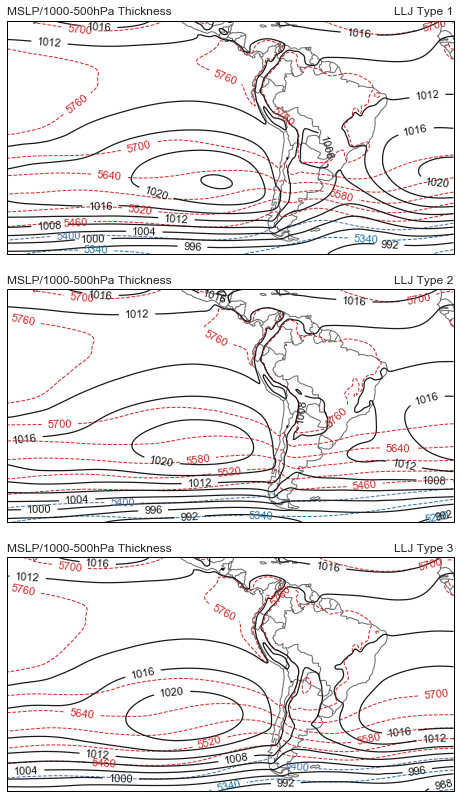

In [21]:
# Create figure
fig = plt.figure(figsize=(8,11.5))
gs = GridSpec(3, 1, figure=fig, hspace=0.04, top=0.97, bottom=0.01)

# Loop through each subplot 
for k in range(nplots):
    
    # Add plot axes 
    ax = fig.add_subplot(gs[k,0], projection=mapcrs)
    
    # Set plot boundaries
    ax.set_extent([-165, -12, -60, 20], crs=mapcrs)    
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, edgecolor='dimgrey')
    ax.add_feature(cfeature.BORDERS, edgecolor='dimgrey')  
    
    thickness_sm = gaussian_filter(thick[k,:,:], sigma=1.5)
    mslp_sm = gaussian_filter(mslp[k,:,:], sigma=1.5) / 100.

    # Plot thickness with multiple colors
    clevs = (np.arange(0, 5400, 60),
             np.array([5400]),
             np.arange(5460, 7000, 60))
    colors = ('tab:blue', 'b', 'tab:red')
    kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    for clevthick, color in zip(clevs, colors):
        cs = ax.contour(lons, lats, thickness_sm, levels=clevthick, colors=color,
                        linewidths=1.0, linestyles='dashed', transform=datacrs)
        plt.clabel(cs, **kw_clabels)

    # Plot MSLP
    clevmslp = np.arange(800., 1120., 4)
    cs2 = ax.contour(lons, lats, mslp_sm, clevmslp, colors='k', linewidths=1.25,
                     linestyles='solid', transform=datacrs)
    plt.clabel(cs2, **kw_clabels)
    
    ax.set_title(type_label[k], loc='right')
    ax.set_title('MSLP/1000-500hPa Thickness', loc='left')

    
# save fig
#plt.savefig(savedir+'slp-thickness.png', dpi=350)
plt.show()